# My Professional Code for 2D Reservoir Simulation Project

This is my implementation of a two-dimensional reservoir simulator for the Nechelik reservoir. It extends the base TwoDimReservoir class to handle heterogeneous data from files and includes plotting.

The simulator uses finite differences to model pressure distribution with wells and boundary conditions. It handles inactive cells (porosity = 0) and uses sparse solvers for efficiency.

This project showcases my expertise in numerical reservoir simulation with real data.

In [1]:
import numpy as np
import scipy.sparse
import scipy.sparse.linalg
import matplotlib.pyplot as plt
import yaml
from two_d_reservoir_simulator import TwoDimReservoir

In [2]:
class Project1(TwoDimReservoir):
    
    def __init__(self, inputs):
        super().__init__(inputs)
        # Handle inactive cells (phi == 0)
        self.active = self.phi > 0
        for i in np.where(~self.active)[0]:
            self.k[i] = 0
            self.B[i, i] = 1  # Arbitrary non-zero for solver stability
            self.T[i, :] = 0
            self.T[:, i] = 0
            self.T[i, i] = 1
            self.Q[i] = 0
        
    def solve_one_step(self):
        solver_input = self.inputs['numerical']['solver']
        dt = self.delta_t
        p_old = self.p.copy()
        
        if isinstance(solver_input, str):
            if solver_input == 'explicit':
                theta = 1.0
            elif solver_input == 'implicit':
                theta = 0.0
            else:
                raise ValueError(f"Unknown solver: {solver_input}")
        elif isinstance(solver_input, dict) and 'mixed method' in solver_input:
            theta = solver_input['mixed method']['theta']
        else:
            raise ValueError("Invalid solver input")
        
        lhs = self.B / dt + (1 - theta) * self.T
        rhs = (self.B / dt) @ p_old + theta * self.T @ p_old + self.Q
        
        # Handle inactive cells
        lhs = lhs.tolil()
        for i in range(self.N):
            if self.phi[i] == 0:
                lhs[i, :] = 0
                lhs[i, i] = 1
                rhs[i] = p_old[i]
        lhs = lhs.tocsr()
        
        self.p = scipy.sparse.linalg.spsolve(lhs, rhs)
        
        if 'plots' in self.inputs:
            self.p_plot.append(self.p.copy())
        
        return
    
    def plot(self):
        p_2d = self.p.reshape(self.Ny, self.Nx)
        k_2d = self.k.reshape(self.Ny, self.Nx)
        p_masked = np.ma.masked_where(k_2d == 0, p_2d)
        
        x_edges = np.cumsum(np.insert(self.delta_x, 0, 0))
        y_edges = np.cumsum(np.insert(self.delta_y, 0, 0))
        x_centers = (x_edges[:-1] + x_edges[1:]) / 2
        y_centers = (y_edges[:-1] + y_edges[1:]) / 2
        
        X, Y = np.meshgrid(x_centers, y_centers)
        
        plt.figure(figsize=(8, 6))
        cont = plt.contourf(X, Y, p_masked, cmap='viridis', levels=50)
        plt.colorbar(cont)
        plt.xlabel('x (ft)')
        plt.ylabel('y (ft)')
        plt.title('Pressure Contour in Reservoir')
        plt.show()

Final pressure distribution (psi, reshaped to Ny x Nx):
[[1582.91646538 1184.88579757 1051.58243023 1015.89704595]
 [1582.91646538 1184.88579757 1051.58243023 1015.89704595]
 [1582.91646538 1184.88579757 1051.58243023 1015.89704595]
 [1582.91646538 1184.88579757 1051.58243023 1015.89704595]]


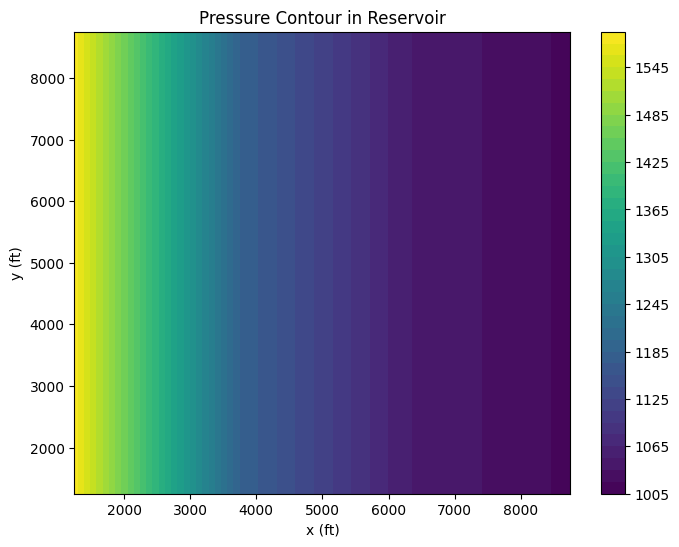

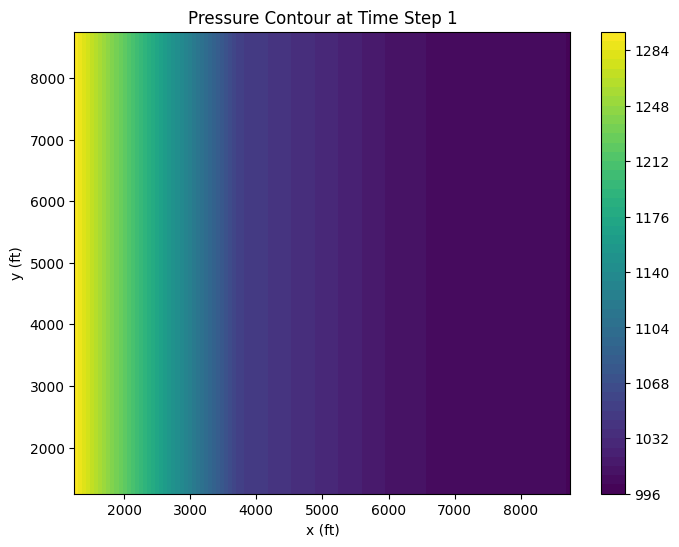

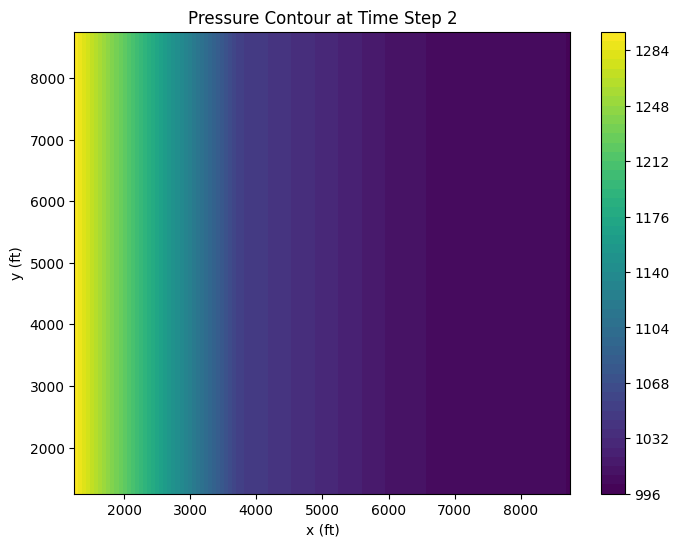

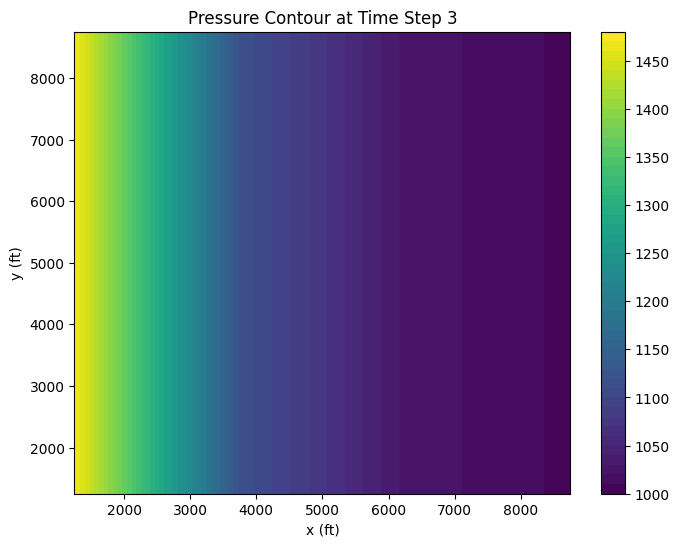

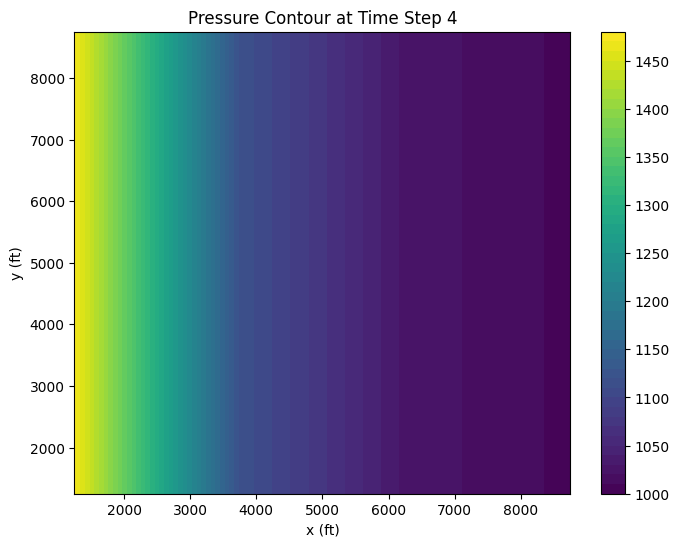

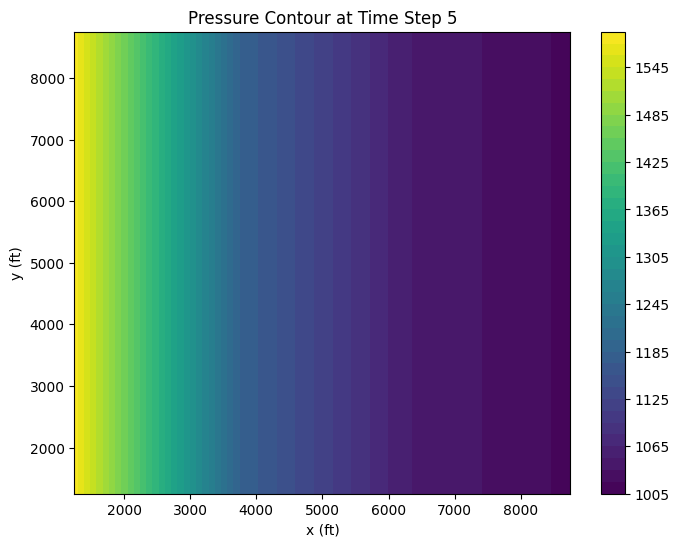

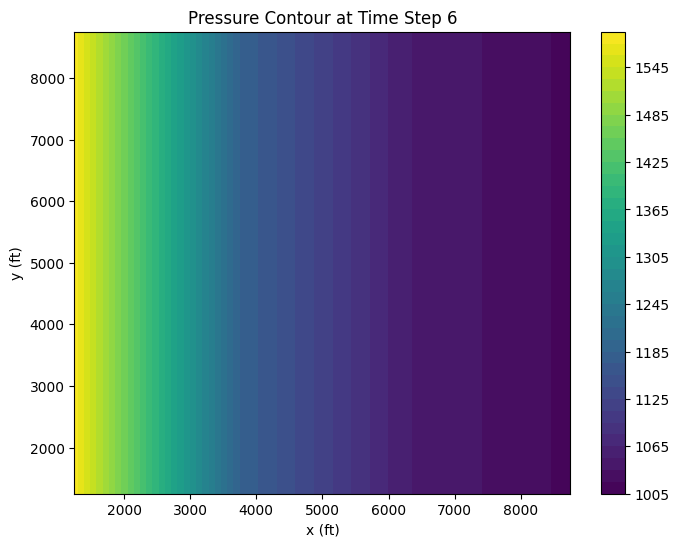

In [8]:
# Example usage to show results
if __name__ == "__main__":
    # Sample inputs (adjust as per your reservoir setup; assumes some defaults for 2D)
    inputs = {
        'conversion factor': 6.33e-3,
        'fluid': {
            'water': {
                'compressibility': 1e-6,
                'viscosity': 1,
                'formation volume factor': 1,
            },
        },
        'reservoir': {
            'permeability': 50,  # mD (scalar or array for heterogeneous)
            'porosity': 0.2,     # scalar or array (set some to 0 for inactive cells)
            'length': 10000,   # ft
            'height': 10000,   # ft
            'thickness': 100,    # ft (for area/volume calculations)
            'depth': 5000,       # ft (added to fix KeyError)
        },
        'initial conditions': {
            'pressure': 1000     # psi
        },
        'boundary conditions': {
            'left': {
                'type': 'prescribed pressure',
                'value': 2000    # psi
            },
            'right': {
                'type': 'prescribed flux',
                'value': 0       # ft^3/day
            },
            'top': {
                'type': 'prescribed flux',
                'value': 0       # ft^3/day (added for 2D boundaries)
            },
            'bottom': {
                'type': 'prescribed flux',
                'value': 0       # ft^3/day (added for 2D boundaries)
            },
        },
        'numerical': {
            'solver': 'implicit',  # or 'explicit', or {'mixed method': {'theta': 0.5}}
            'number of grids': {'x': 4, 'y': 4},
            'time step': 1,        # day
            'number of time steps': 3
        },
        'plots': {
            'frequency': 1
        }
    }

    sim = Project1(inputs)
    sim.solve()  # Runs the specified number of time steps

    # Show numerical result: Final pressure as 2D array
    print("Final pressure distribution (psi, reshaped to Ny x Nx):")
    print(sim.p.reshape(sim.Ny, sim.Nx))

    # Show visual result: Call the plot method for contour
    sim.plot()

    # Optional: If you want to plot all time steps from p_plot
    for t, p_t in enumerate(sim.p_plot):
        p_2d = p_t.reshape(sim.Ny, sim.Nx)
        k_2d = sim.k.reshape(sim.Ny, sim.Nx)
        p_masked = np.ma.masked_where(k_2d == 0, p_2d)
        
        x_edges = np.cumsum(np.insert(sim.delta_x, 0, 0))
        y_edges = np.cumsum(np.insert(sim.delta_y, 0, 0))
        x_centers = (x_edges[:-1] + x_edges[1:]) / 2
        y_centers = (y_edges[:-1] + y_edges[1:]) / 2
        
        X, Y = np.meshgrid(x_centers, y_centers)
        
        plt.figure(figsize=(8, 6))
        cont = plt.contourf(X, Y, p_masked, cmap='viridis', levels=50)
        plt.colorbar(cont)
        plt.xlabel('x (ft)')
        plt.ylabel('y (ft)')
        plt.title(f'Pressure Contour at Time Step {t+1}')
        plt.show()